In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from pydub import AudioSegment
from pydub.utils import mediainfo

from IPython.display import Audio

In [5]:
def generate_spectrogram(x, sr, n_fft=2048, hop_length=512, show=False):
    """
    A Spectrogram chops up the duration of the sound signal into smaller time segments and 
    then applies the Fourier Transform to each segment, to determine the frequencies contained in that segment.
    """
    X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    Xdb = librosa.amplitude_to_db(abs(X))
    if show == True:
        librosa.display.specshow(Xdb, sr=sr, cmap='viridis', x_axis='time', y_axis='hz')
    return(Xdb)

def generate_mel_spectrogram(x, sr, n_fft=2048, hop_length=512, show=False):

    """
    - It uses the Mel Scale instead of Frequency on the y-axis.
    - It uses the Decibel Scale instead of Amplitude to indicate colors.
    """
    
    sgram = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
    
    # Separate a complex-valued spectrogram D into its magnitude (S) and phase (P)
    sgram_mag, _ = librosa.magphase(sgram)
    
    # Compute the mel spectrogram -> convert frequency in mel-scale
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    
    # use the decibel scale to get the final Mel Spectrogram
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram)
    
    # Display the mel spectrogram
    if show == True:
        librosa.display.specshow(mel_sgram, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        
    return(mel_sgram)

In [6]:
data_path = "/Data/soundsolution/records/barnacle+goose.json/XC484447-ab_201907_01_02_yom_0217.mp3"

audio = AudioSegment.from_mp3(data_path)
arr = np.array(audio.get_array_of_samples(), dtype=float)
info =  mediainfo(data_path)
sr = int(info["sample_rate"])
n_channels = info["channels"]

print("Sampling rate: {}, N. channels: {}".format(sr, n_channels))


Sampling rate: 44100, N. channels: 2


In [7]:
# Variables
l_segment = 3000 # ms

n_fft = 2048
hop_length = 1024

 ## Short-time Fourier Transform (STFT)
To get that more granular view and see the frequency variations over time, we use the STFT algorithm (Short-Time Fourier Transform). 
The STFT is another variant of the Fourier Transform that breaks up the audio signal into smaller sections by using a sliding time window. 
It takes the FFT on each section and then combines them. It is thus able to capture the variations of the frequency with time.

![](fft.png)

In [9]:
# The FFT size controls the duration of each frame, but not (directly) how much overlap there is between successive frames, that's the role of hop_length (distance between consecutives FFTs)

# When computing an STFT, you compute the FFT for a number of short segments. These segments have the length n_fft. Usually these segments overlap (in order to avoid information loss), so 
# the distance between two segments is often not n_fft, but something like n_fft/2. The name for this distance is hop_length. It is also defined in samples.

# So when you have 1000 audio samples, and the hop_length is 100, you get 10 features frames (note that, if n_fft is greater than hop_length, you may need to pad).
# Examples: for 10 second of audio at 22050 and hop_length = 512, we have 430 bins in the x-axis

fft_window = round((n_fft / sr) * 1000)
hop_window = round((hop_length / sr) * 1000)
print("Each fft window is {} milliseconds, windows overlap by {} milliseconds".format(fft_window, hop_window))

Each fft window is 46 milliseconds, windows overlap by 23 milliseconds


In [24]:
round(((1024 / 16000) * 3000) / 2)

96

In [ ]:
round(((2048 / 16000) * 3000) / 4)

In [14]:
fft_window * 3

138

In [9]:
# bit depth: 1-4. 1=8 2=16 3=24 4=32
audio.sample_width

2

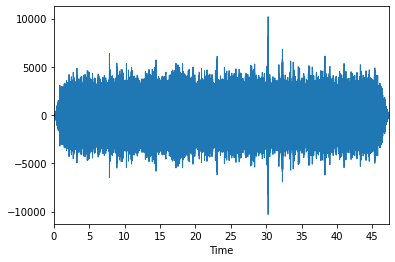

In [13]:
librosa.display.waveplot(arr, sr)

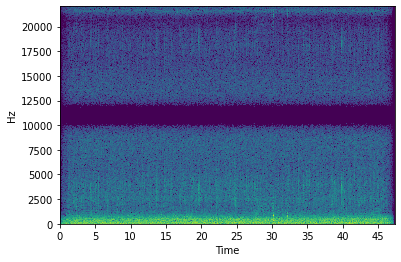

In [14]:
a = generate_spectrogram(arr, sr, show=True)

## Mel Spectrogram Hyperparameters

Frequency Bands
- fmin — minimum frequency
- fmax — maximum frequency to display
- n_mels — number of frequency bands (ie. Mel bins). This is the height of the Spectrogram

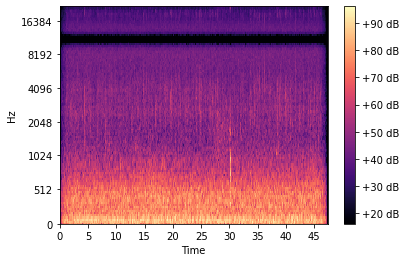

In [15]:
a = generate_mel_spectrogram(arr, sr, show=True)

## Decibels mathematics

The term dB FS (or dBFS) means decibels relative to full scale. It is used for amplitude levels in digital systems with a maximum available peak level, e.g., PCM encoding, 
where 0 dB FS is assigned to the maximum level. All peak measurements will be negative numbers.

### Audio normalization

https://superkogito.github.io/blog/rmsnormalization.html#:~:text=Audio%20normalization%20is%20a%20fundamental,Mean%20Square%20(RMS)%20normalization.

Audio normalization is a fundamental audio processing technique that consists of applying a constant amount of gain to an audio in order to bring its amplitude to a target level. 
A commonly used normalization technique is the **Root Mean Square (RMS) normalization**. 

In general there are two principal types of audio normalization:

- Peak normalization which adjusts the recording based on its highest signal level.
- Loudness normalization which adjusts the recording based its perceived loudness.

RMS normalization falls under the latter, where the perceived loudness level is determined using the root mean square of the signal. The result is then used to compute the gain value used in the normalization. Since the gain value is constant and applied across the entire recording, the normalization does not affect the signal-to-noise ratio and the relative dynamics

\begin{equation}
    y[n]=\sqrt{\frac{N-10\left(\frac{r}{20}\right)}{\sum_{i=0}^{N-1} x^{2} \left[ i\right]}} \cdot x[n]
\end{equation}

With 

- x[n] as the original signal
- y[n] the normalized signal
- N the length of x[n]
- r the input RMS level in dB

rms is a measure of average amplitude, which pydub provides as audio_segment.rms and also provides a convenience method that provides this value converted to dBFS (audio_segment.dBFS)

If you want a group of audio files to be the same average amplitude, basically you choose an average amplitude (in dBFS, -20 in the example below), and adjust as needed:

In [33]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

normalized_audio = match_target_amplitude(audio, -20.0)

print("Before normalization {} dbFS, after normalization {}, dbFS".format(audio.dBFS, normalized_audio.dBFS))

Before normalization -27.996788465708363 dbFS, after normalization -19.996819714504753, dbFS


In [38]:
import inspect

print(inspect.getsource(audio.apply_gain))

    def apply_gain(self, volume_change):
        return self._spawn(data=audioop.mul(self._data, self.sample_width,
                                            db_to_float(float(volume_change))))



In [31]:
## Convert amplitude to dbFS
value = audio.rms

# If value is between 1 and -1 -> bit depth of 1
valueDBFS = 20*np.log10(abs(value))

# If values are between another range, for example 16 bits then
valueDBFS = 20*np.log10(abs(value) / np.power(2, 16-1))

In [47]:
audio.max_dBFS

-10.097063975063854

In [48]:
normalized_audio.max_dBFS

-2.1002029749874267

### More generally:

valueDBFS = 20*np.log10(abs(value) / maxValue)

In [21]:
normalized_audio.dBFS

-19.996819714504753